# Importing Packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from skimage import color

import torch

from tqdm import tqdm

import os

# Build model class
we should make a class for data preprocessing, because data preprocessing steps for all image processing problems are more or less the same!

In [2]:
data_path = "../input/brain-tumor-classification-mri/"

# To get the image_shape, create a list containing all the 1st and 2nd dimension of the data samples. Then take average
image_shape = (385, 372)           
target_data_path = "./data"



class build_data:
    def __init__(self, data_path, image_shape, target):
        
        self.data_path = data_path
        self.image_shape = image_shape
        self.label = {}
        self.data_set = []
        self.target = target
    def build(self):    
        label_id = 0
        for level_1 in os.listdir(self.data_path):
            level_1_path = os.path.join(self.data_path, level_1)

            for class_label in tqdm(os.listdir(level_1_path)):
                level_2_path = os.path.join(level_1_path, class_label)

                if(class_label not in self.label):
                    self.label[class_label] = label_id
                    label_id +=1
                for image in os.listdir(level_2_path):
                    image_path = os.path.join(level_2_path, image)
                    image_arr = resize(color.rgb2gray(io.imread(image_path)), image_shape)
                    datapoint = np.array([np.array(image_arr), self.label[class_label]])
                    self.data_set.append(datapoint)
        
        np.save(self.target, self.data_set)

bd = build_data(data_path, image_shape, target_data_path)
bd.build()

100%|██████████| 4/4 [00:07<00:00,  1.92s/it]


# Loading data...

In [2]:
data = np.load("./data.npy", allow_pickle = True)
np.random.shuffle(data)

# Pre-processing steps
1. There is a problem with memory management for this cell
2. First time when you run this cell, there will be an error, so your session will restart
3. Go back to the first cell, and run it
4. skip the second cell
5. Load the data at 3rd cell
6. Then run this pre-processing cell once more, error is not likely to happen again

In [4]:
def normalize(x):
    x = x/(np.max(x)-np.min(x))
    return x
def train_test_split(data, split_ratio):
    np.random.shuffle(data)
    train_size = int(data.shape[0]*split_ratio)
    test_data = data[:train_size]
    train_data = data[train_size:]
    return (train_data, test_data)



def make_tensor(data):
    x=[]
    y=[]
    for data_item in tqdm(data):
        x.append(data_item[0])
        y.append(data_item[1])
    x = normalize(np.array(x))
    x = torch.tensor(x, requires_grad = False).float()
    x = torch.unsqueeze(x,1)
    y = torch.tensor(y, requires_grad = False)
    return (x, y)

train_data, test_data = train_test_split(data, 0.2)
print(train_data.shape)
X_train, y_train = make_tensor(train_data)

X_train.shape

(2612, 2)

# End of Data Pre-processing-------------We've got X_train, y_train

# Defining the model

In [51]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary    #Download torchsummary using !pip install torchsummary in the terminal

class model(nn.Module):
    def __init__(self, x, total_classes):
        super(model, self).__init__()
        self.input_filter = x.shape[1]
        self.input_x_dim = x.shape[2]
        self.input_y_dim = x.shape[3]
        self.total_classes = total_classes
        self.dense_ip = None
        
        
        self.conv1 = nn.Conv2d(self.input_filter, 16, 2)
        self.conv2 = nn.Conv2d(16, 64, 2)
        self.conv3 = nn.Conv2d(64, 128, 2)
        self.conv4 = nn.Conv2d(128, 256, 3)
        self.conv5 = nn.Conv2d(256, 512, 4)
        if(self.dense_ip is None):
            a = self.forwardConv(torch.randn(1, self.input_filter, self.input_x_dim, self.input_y_dim))
        
        self.fc1 = nn.Linear(self.dense_ip, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.op = nn.Linear(32, total_classes)
        
        
        
    def forwardConv(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = F.max_pool2d(F.relu(self.conv3(x)), 2)
        x = F.max_pool2d(F.relu(self.conv4(x)),2)
#         x = F.relu(self.conv5(x))
        
        
        x = x.view(x.shape[0], x.shape[1]*x.shape[2]*x.shape[3])
        if(self.dense_ip is None):
            self.dense_ip = x.shape[-1]
        
        return x
        
    def forward(self, x):
        x = self.forwardConv(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.op(x)
        
        
        return x

model1 = model(X_train, 4)
if(torch.cuda.is_available()):
    model1 = model1.to("cuda")
summary(model1, (X_train[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 384, 371]              80
            Conv2d-2         [-1, 64, 191, 184]           4,160
            Conv2d-3          [-1, 128, 94, 91]          32,896
            Conv2d-4          [-1, 256, 45, 43]         295,168
            Linear-5                  [-1, 256]      30,277,888
            Linear-6                  [-1, 128]          32,896
            Linear-7                   [-1, 64]           8,256
            Linear-8                   [-1, 32]           2,080
            Linear-9                    [-1, 4]             132
Total params: 30,653,556
Trainable params: 30,653,556
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.55
Forward/backward pass size (MB): 46.69
Params size (MB): 116.93
Estimated Total Size (MB): 164.17
--------------------------------

# Train...

In [60]:
import torch.optim as optim


class Train_Validate:
    def __init__(self, model, device):
        self.model = model
        self.device = device
#         self.model.to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr = 1e-3)
        self.criterion = nn.CrossEntropyLoss()
    
    
    def train(self, X, y, batch_size, epochs):
        error_log = []
        for epoch in tqdm(range(epochs)):
            for batch in range(0, X.shape[0], batch_size):
                X_batch = X[batch: batch+batch_size]
                y_batch = y[batch: batch+batch_size]
                
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                
                self.optimizer.zero_grad()                      #1
                prediction = self.model(X_batch)                #2
                loss = self.criterion(prediction, y_batch)      #3
                
                error_log.append(loss)                      
                loss.backward()                                 #4
                
                self.optimizer.step()                           #5
        plt.plot(error_log)
        plt.show()
    
    def evaluate(self, X, y):
        correct = 0
        self.model = self.model.to("cpu")
        for i in tqdm(range(len(X))):
            data = X[i]
            data = torch.unsqueeze(data, 0)
            _, pred = torch.max(self.model(data), 1)
            if(pred == y[i]):
                correct+=1
        return correct/len(X)
        
        
################## F1 score predictor ########## we'll see later####
#         F1 = np.array([[0., 0.],
#                        [0., 0.]])
#         _, predictions = torch.max(self.model(X), 1)
#         i = 0
#         correct = 0
#         for pred in predictions:
#             if(pred == y[i]):
#                 correct += 1
#             if(pred == 0 ):
#                 if(y[i] == 0):
#                     F1[0][0] += 1
#                 else:
#                     F1[0][1] += 1
#             elif(pred != 0 and y[i] !=0):
#                 F1[1][1] += 1
#             else:
#                 F1[1][0] += 1
            
#             i+=1
#         accuracy = correct/len(X)
#         return (accuracy, F1)
        
 



In [61]:

model1 = model(X_train, 4)
model1.to("cuda")
summary(model1, (X_train[0].shape))
train_obj = Train_Validate(model1, "cuda")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 384, 371]              80
            Conv2d-2         [-1, 64, 191, 184]           4,160
            Conv2d-3          [-1, 128, 94, 91]          32,896
            Conv2d-4          [-1, 256, 45, 43]         295,168
            Linear-5                  [-1, 256]      30,277,888
            Linear-6                  [-1, 128]          32,896
            Linear-7                   [-1, 64]           8,256
            Linear-8                   [-1, 32]           2,080
            Linear-9                    [-1, 4]             132
Total params: 30,653,556
Trainable params: 30,653,556
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.55
Forward/backward pass size (MB): 46.69
Params size (MB): 116.93
Estimated Total Size (MB): 164.17
--------------------------------

# Run training... and saving the model

100%|██████████| 20/20 [01:56<00:00,  5.84s/it]


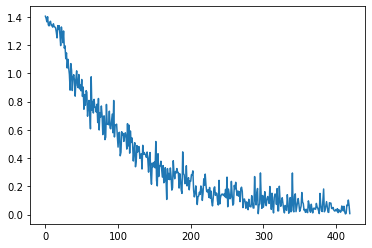

In [13]:
train_obj.train(X_train, y_train, 128, 20)

torch.save(model1, "./model.pt")

# loading the saved model, training_accuracy

In [62]:
model1 = torch.load("./model.pt")
train_obj.model = model1
train_accuracy = train_obj.evaluate(X_train, y_train)
print("training accuracy is {}".format(train_accuracy))


# model1 = train_obj.model.to("cpu")
# def evaluate(X, y):
#     correct = 0

#     for i in tqdm(range(len(X))):
#         data = X[i]
#         data = torch.unsqueeze(data, 0)
# #         data = data.to("cuda")
        
#         pred = model1(data)
#         _, id = torch.max(pred, 1)
#         if(id == y[i]):
#             correct+=1
#     return correct/len(X)


# accuracy = evaluate(X_train, y_train)
# print(accuracy)

100%|██████████| 2612/2612 [03:34<00:00, 12.18it/s]

training accuracy is 0.9525267993874426


# Validate dataset

In [63]:
X_test, y_test = make_tensor(test_data)
test_accuracy = train_obj.evaluate(X_test, y_test)
print(test_accuracy)

100%|██████████| 652/652 [00:53<00:00, 12.28it/s]

0.8542944785276073
